In [1]:
import importlib
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime # for 
from shapely.geometry import Point

dir = os.getcwd()
os.chdir("/home/clueken/master/open_data")
import open_data_utils
importlib.reload(open_data_utils)
from open_data_utils import add_world_map, avg_by_time, detrend_hawaii#import the module here, so that it can be reloaded.
os.chdir(dir)

## How to get data from file

In [40]:
#print(os.listdir("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/"))
file = '/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_chl_surface-insitu_6_allvalid.nc'

dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
#dataset.value_std_dev.values

## Get and filter data for Australia

In [2]:
save = False
filter_for = "tower"
file_dir = '/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc'
f = os.listdir(file_dir)

filenames = []
for file in f:
    filenames.append(file) if filter_for in file else None

names = []
geometry = []

for i,f in enumerate(filenames):
    file = os.path.join(file_dir, f)
    dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
    names.append(file) if dataset.site_country == "Indonesia" else None
print(len(names))
if save:
    np.savetxt(f"/home/clueken/master/open_data/data/obspack_indo_{filter_for}.txt", np.array(names), fmt="%s")

0


In [ ]:
# to find good data
with open(f"/home/clueken/master/open_data/data/obspack_austr_surface.txt") as f:
        filenames = f.read().splitlines()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ind = [1,2,3]#np.arange(len(filenames))#[0,1,2,3,7,8,10]
for i in ind:
    print(i)
    dataset = dataset = xr.open_mfdataset(filenames[i], combine='by_coords',concat_dim='None')
    plt.plot(dataset.time, dataset.value.values)
    plt.show()
    fig, ax = plt.subplots()
    ax.scatter(dataset.longitude.values[0], dataset.latitude.values[0], color="red")
    gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[world.name == "Australia"].plot(ax = ax)
    plt.show()

In [84]:
with open(f"/home/clueken/master/open_data/data/obspack_austr_surface.txt") as f:
        filenames = f.read().splitlines()

#np.savetxt(f"/home/clueken/master/open_data/data/obspack_austr_surface_land.txt", np.array(names)[1:4], fmt="%s")

## Plot positions and measurements of measurements in Australia

Measurements for /mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cgo_surface-flask_1_representative.nc are at different positions. (Not shown)


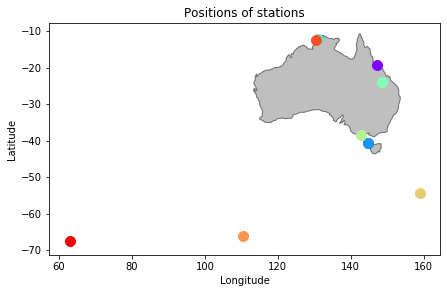

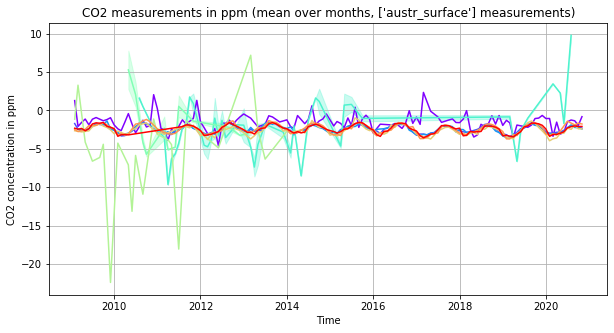

In [4]:
########################### inputs ####################################
types = ["austr_surface"]#["newzea_surface","austr_surface_land"]#["austr_surface_sea", "austr_surface_land"] #
cmaps = ["rainbow"]#["GnBu", "OrRd"] #
same_plot = True

clip = [350, 430]
mean = "months"
err_mode = "std_dev"
detrend_flag = True
min_time = np.datetime64("2009")
########################### inputs ####################################
num_plots = len(types) if not same_plot else 1

fig1, ax1 = plt.subplots(figsize=(7, 7))
fig2, ax2 = plt.subplots(num_plots, figsize=(10, 5*num_plots))

ax1.set_title("Positions of stations")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

ax2 = [ax2] if len(types) == 1 else ax2
for a in ax2:
    a.set_xlabel("Time")
    a.set_ylabel("CO2 concentration in ppm")
    a.grid()

mean_dict = dict(years=1, months=2, days=3, hours=4, minutes=5, seconds=6)
mean_ind = mean_dict[mean]

for i,key in enumerate(types):
    
    with open(f"/home/clueken/master/open_data/data/obspack_{key}.txt") as f:
        filenames = f.read().splitlines()

    if len(filenames) == 0:
        print(f"No data for type {key} in /home/clueken/master/open_data/data/obspack_austr_{key}.txt")
        continue
    
    a = ax2[i] if not same_plot else ax2[0]
    a.set_title(f"CO2 measurements in ppm (mean over {mean}, {key if not same_plot else types} measurements)")

    colors = cm.get_cmap(cmaps[i])(np.linspace(0 if cmaps[i]=='rainbow' else 0.5, 1, len(filenames)))
    
    fig1, ax1 = add_world_map(fig1, ax1, country="Australia", color="gray", alpha=0.5, edgecolor="black")
    
    for j, f in enumerate(filenames):
        
        dataset = xr.open_mfdataset(f, combine='by_coords',concat_dim='None')
        
        try:
            assert len(np.unique(dataset.longitude)) == 1
        except AssertionError:
            print(f"Measurements for {f} are at different positions. (Not shown)")
            continue
        
        ax1.scatter(dataset.longitude[0], dataset.latitude[0], color=colors[j], s=100)
        
        values, errors, times = avg_by_time(dataset, mean_ind, err_mode)
        values = values*1e6        
        errors = errors*1e6
        mask = (clip[0] < values) * (values < clip[1]) * (times > min_time) if clip is not None else times > min_time
        values = values[mask]
        times = times[mask]
        if len(values) == 0:
            continue
        values = detrend_hawaii(values, times) if detrend_flag else values
        try:
            a.fill_between(times, values-errors, values+errors, alpha=0.3, color=colors[j])
        except:
            None 

        a.plot(times, values, color=colors[j])

#fig1.savefig("/home/clueken/master/open_data/figures/obspack/map_surface.pdf")
#fig2.savefig("/home/clueken/master/open_data/figures/obspack/data_sea_land.pdf")

In [6]:
fig2.savefig("/home/clueken/master/open_data/figures/obspack/data_surface_detr.pdf")

## Get info of measurements in Australia

In [5]:
types = ["surface", "aircraft", "tower"]

for i,key in enumerate(types):
    with open(f"/home/clueken/master/open_data/data/obspack_austr_{key}.txt") as f:
        filenames = f.read().splitlines()
    print(f"Datasets for {key}-measurements:")
    for j, f in enumerate(filenames):

        dataset = xr.open_mfdataset(f, combine='by_coords',concat_dim='None')
        print(f"Filename: {f}")
        print(dataset)


Datasets for surface-measurements:
Filename: /mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cfa_surface-flask_2_representative.nc
<xarray.Dataset>
Dimensions:                     (calendar_components: 6, dim_concerns: 6, mip_nmodels: 17, obs: 1000)
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels, obs
Data variables:
    time                        (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
    start_time                  (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
    midpoint_time               (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
    datetime                    (obs) |S100 dask.array<chunksize=(1000,), meta=np.ndarray>
    time_decimal                (obs) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    time_components             (obs, calendar_components) float64 dask.array<chunksize=(1000, 6), me

## Compare land to sea 

In [9]:
def select_and_detrend(v_data, t_data, start, end, v_key):
    df_list = []
    for i, z in enumerate(zip(v_data, t_data)):
        v, t = z
        ind = (t > np.datetime64(start)) *(t < np.datetime64(end))
        v = v[ind]
        t = t[ind]
        v = detrend_hawaii(v, t)
        df_list.append(pd.DataFrame(np.array([t, v]).T, columns=["t", f"{v_key}_{i}"])) 
    return df_list

def merge_many(dfs, sort_by=None, **kwargs):
    df = dfs[0]
    for i, df2 in enumerate(dfs):
        if i == 0:
            continue
        df = df.merge(df2, **kwargs)
    df = df.sort_values(sort_by).reset_index(drop=True)
    return df

In [10]:
avg_index = 2
with open(f"/home/clueken/master/open_data/data/obspack_tasm_surface.txt") as f:
    filenames = f.read().splitlines()
v_data = []
t_data = []
for f in filenames:
    dataset = xr.open_mfdataset(f, combine='by_coords', concat_dim='None')
    v, _, t = avg_by_time(dataset, avg_index)
    v_data.append(v)
    t_data.append(t)

v_land = np.array(v_data)*1e6
t_land = np.array(t_data)

with open(f"/home/clueken/master/open_data/data/obspack_austr_surface_sea.txt") as f:
    filenames = f.read().splitlines()
v_data = []
t_data = []
for f in filenames:
    dataset = xr.open_mfdataset(f, combine='by_coords', concat_dim='None')
    v, _, t = avg_by_time(dataset, avg_index)
    v_data.append(v)
    t_data.append(t)

v_sea = np.array(v_data)*1e6
t_sea = np.array(t_data)

df_land = select_and_detrend(v_land, t_land, '2017', '2020', "v_land")
df_sea = select_and_detrend(v_sea, t_sea, '2017', '2020', "v_sea")

df_land = merge_many(df_land, sort_by='t', how='outer', on='t')
df_sea = merge_many(df_sea, sort_by='t', how='outer', on='t')

df_land['mean'] = df_land.iloc[:, 1:].mean(axis=1)
df_land['std'] = df_land.iloc[:, 1:].std(axis=1)
df_sea['mean'] = df_sea.iloc[:, 1:].mean(axis=1)
df_sea['std'] = df_sea.iloc[:, 1:].std(axis=1)

No error avaliable for data.


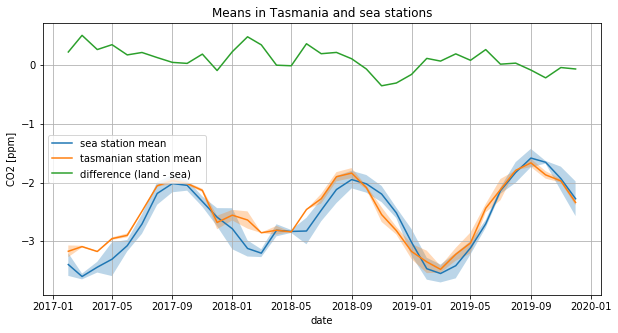

In [14]:
plt.figure(figsize=(10,5))
plt.title("Means in Tasmania and sea stations")
plt.grid()
plt.xlabel("date")
plt.ylabel("CO2 [ppm]")
plt.plot(df_sea['t'], df_sea['mean'], label="sea station mean")
plt.fill_between(df_sea['t'], df_sea['mean']-df_sea['std'], df_sea['mean']+df_sea['std'], alpha=0.3)
plt.plot(df_land['t'], df_land['mean'], label="tasmanian station mean")
plt.fill_between(df_land['t'], df_land['mean']-df_land['std'], df_land['mean']+df_land['std'], alpha=0.3)
plt.plot(df_land['t'], df_land['mean']-df_sea['mean'], label="difference (land - sea)")
plt.legend()

## Cells for other testing

In [ ]:

file = '/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_chl_surface-insitu_6_allvalid.nc'
dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
v, e, t = avg_by_time(dataset)

In [ ]:
df_means = pd.merge(df_land[["t","mean"]], df_sea[["t", "mean"]], how='outer', on='t')
plt.scatter(df_means[["t"]], df_means["mean_x"]-df_means["mean_y"])